In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import numpy as np
import matplotlib.pyplot as plt
import PIL

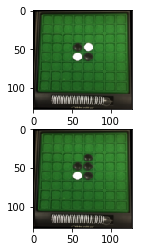

In [2]:
img1 = PIL.Image.open("Othello.png")
img1 = (np.array(img1.getdata(), dtype="float32") / 256).reshape(128,128,4)[:,:,0:3].transpose((2, 0, 1))
img2 = PIL.Image.open("Othello_3_2.png")
img2 = (np.array(img2.getdata(), dtype="float32") / 256).reshape(128,128,4)[:,:,0:3].transpose((2, 0, 1))

plt.subplot(211)
plt.imshow(img1.transpose((1, 2, 0)))
plt.subplot(212)
plt.imshow(img2.transpose((1, 2, 0)))
plt.show()

In [16]:
"""
    X: -1 x 3 x 128 x 128
    Conv(50, 5) + Maxpool(4)
    -1 x 50 x 31 x 31
    Conv(4) + Maxpool(3)
    -1 x 4 x 9 x 9
    Reshape(324)
    -1 x 324
    
    Connected(512)
    -1 x 512
    
    Append(Y: -1 x 65) [0-64: where, 65: whom (0=black, 1=white)]
    -1 x 577
    Connected(256)
    -1 x 256
    
    Reshape(4, 8, 8)
    -1 x 4 x 8 x 8
    Conv(50) + Upscale(4)
    -1 x 50 x 32 x 32
    Conv(3) + Upscale(4)
    -1 x 3 x 128 x 128
"""

class BOThello(nn.Module):
    def __init__(self):
        super(BOThello, self).__init__()
        
        self.conv_in_1 = nn.Conv2d(3, 50, 5)
        self.conv_in_2 = nn.Conv2d(50, 4, 5)
        
        self.conn_1 = nn.Linear(324, 512)
        self.conn_2 = nn.Linear(577, 256)
        
        self.conv_out_1 = nn.Conv2d(4, 50, 6)
        self.conv_out_2 = nn.Conv2d(50, 3, 8)
    
    # x = image, y = player action
    def forward(self, x, y):
        x = self.conv_in_1(x)
        x = F.relu(F.max_pool2d(x, (4, 4)))
        x = self.conv_in_2(x)
        x = F.relu(F.max_pool2d(x, (3, 3)))
        
        x = x.view(-1, 324)
        x = self.conn_1(x)
        x = F.relu(x)
        
        x = torch.cat((x, y), dim=1)
        
        x = self.conn_2(x)
        x = F.relu(x)
        x = x.view(-1, 4, 8, 8)
        
        x = F.upsample(x, scale_factor=4)
        x = self.conv_out_1(x)
        x = F.upsample(x, scale_factor=5)
        x = self.conv_out_2(x)
        
        return x
    
bot = BOThello()


In [17]:
image = Variable(torch.from_numpy(img1.reshape(1, *img1.shape)))
player_action = torch.zeros(1, 65)
player_action[0, 3 * 8 + 2] = 1
res = bot(image, Variable(player_action))

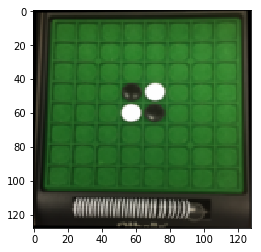

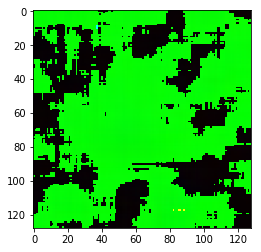

In [18]:
plt.imshow(np.array(img1).transpose((1, 2, 0)))
plt.show()
plt.imshow(np.array(res.data)[0].transpose((1, 2, 0)))
plt.show()


In [23]:
crit = nn.MSELoss()
optimizer = opt.SGD(bot.parameters(), lr=0.01, momentum=0.5)

In [ ]:
while True: # Train the network on img1->img2
    image = Variable(torch.from_numpy(img1.reshape(1, *img1.shape)))
    wanted = Variable(torch.from_numpy(img2.reshape(1, *img2.shape)))
    
    player_action = torch.zeros(1, 65)
    player_action[0, 3 * 8 + 2] = 1
    res = bot(image, Variable(player_action))
    
    optimizer.zero_grad()
    
    loss = crit(res, wanted)
    loss.backward()
    optimizer.step()
    
    print(loss.data[0])
    #plt.imshow(np.array(res.data)[0].transpose((1, 2, 0)))
    #plt.show()

print("Done!")

0.014438261277973652
0.014436033554375172
0.014433762989938259
0.01443152129650116
0.01442935224622488
0.014427103102207184
0.01442490890622139
0.01442269328981638
0.014420446008443832
0.014418196864426136
0.014416005462408066
0.014413787983357906
0.01441157516092062
0.01440928503870964
0.014407065697014332
0.014404837973415852
0.01440266240388155
0.014400453306734562
0.014398262836039066
0.014396061189472675
0.014393876306712627
0.014391741715371609
0.01438958290964365
0.014387388713657856
0.014385242946445942
0.014383014291524887
0.014380872249603271
0.014378716237843037
0.014376584440469742
0.014374437741935253
0.01437227800488472
0.014370094984769821
0.014367914758622646
0.014365698210895061
0.014363507740199566
0.014361273497343063
0.01435907930135727
0.014356918632984161
0.014354713261127472
0.01435253769159317
0.01435029972344637
0.014348004013299942
0.014345834963023663
0.014343608170747757
0.014341368339955807
0.01433909684419632
0.014336897991597652
0.01433466374874115
0.0143

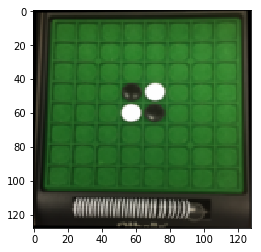

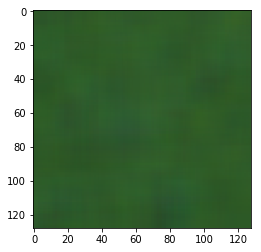

In [27]:
plt.imshow(np.array(img1).transpose((1, 2, 0)))
plt.show()
plt.imshow(np.array(res.data)[0].transpose((1, 2, 0)))
plt.show()
